In [8]:
%matplotlib widget

import numpy as np
import pandas as pd
import math
import tensorflow as tf
import tensorflow_probability as tfp

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import jacques
from jacques import kcqe
from jacovid import util

In [2]:
data = util.load_data()
data

,location,date,inc_hosp,population,rate
1015,AK,2020-10-01,3.0,731545,0.410091
1016,AK,2020-10-02,7.0,731545,0.956879
1017,AK,2020-10-03,5.0,731545,0.683485
1018,AK,2020-10-04,5.0,731545,0.683485
1019,AK,2020-10-05,1.0,731545,0.136697
...,...,...,...,...,...
38796,WY,2021-06-27,10.0,578759,1.727835
38797,WY,2021-06-28,9.0,578759,1.555051
38798,WY,2021-06-29,7.0,578759,1.209484
38799,WY,2021-06-30,8.0,578759,1.382268


In [45]:
data = data[['location', 'date', 'rate']]
data

,location,date,rate
1015,AK,2020-10-01,0.410091
1016,AK,2020-10-02,0.956879
1017,AK,2020-10-03,0.683485
1018,AK,2020-10-04,0.683485
1019,AK,2020-10-05,0.136697
...,...,...,...
38796,WY,2021-06-27,1.727835
38797,WY,2021-06-28,1.555051
38798,WY,2021-06-29,1.209484
38799,WY,2021-06-30,1.382268


In [455]:
def trailing_taylor_coefs_taylor_update(loc_data,
                                        target_var,
                                        taylor_degree = 1,
                                        taylor_innovations = 1,
                                        update_frequency = 1,
                                        window = 21,
                                        include_dow = True,
                                        ew_span = 14,
                                        realtime = True):
    '''
    Estimate the parameters of a Taylor polynomial fit to a rolling
    trailing window, with the coefficients in consecutive windows
    updated according to a Taylor process with noise.
    
    Parameters
    ----------
    loc_data: a pandas data frame with data for one location
    target_var: variable for which to calculate neighborhoods
    taylor_degree: degree of the Taylor polynomial
    taylor_innovations: 'all' or 'highest'
    window: window size
    ew_span: span for exponential weighting of observations.
        No weighting is done if ew_span is None.
    realtime: if True, get estimates at each time point as though in real time
    
    Returns
    -------
    Data frame with the same number of rows as the input data and columns
    `target_var + '_taylor_' + d` for each degree d in 0, 1, 2
    
    Notes
    -----
    In window t, the updated coefficients are A @ beta_{t-1}, where A is
    [ 1  1  0.5  ...  1 / D!    
      0  1  1    ...  1 / (D-1)!
      ...
      0  0  0    ...  1           ]
      
    With D = 2, this is
    
    [ 1  1  0.5 ]                [ 0 ]
    [ 0  1  1   ] @ beta_{t-1} + [ 0 ]
    [ 0  0  1   ]                [ gamma_t ]
    
    Suppose we start with a vector alpha of length taylor_degree + [T - (taylor_degree - 1)] + 6
    We can convert this to the vector of taylor coefficients by setting
    beta_1 = [I_3  0  ...  0 ] @ alpha
    
             [ 1  1  0.5 ]                [ 0  0  0  0  0 ... 0 ]
    beta_2 = [ 0  1  1   ] @ beta_{t-1} + [ 0  0  0  0  0 ... 0 ] @ alpha
             [ 0  0  1   ]                [ 0  0  0  1  0 ... 0 ]
    
             [ 1  1  0.5  0 ... 0]
           = [ 0  1  1    0 ... 0] @ alpha
             [ 0  0  1    1 ... 0]
    
             [ 1  1  0.5 ]                [ 0  0  0  0  0 ... 0 ]
    beta_3 = [ 0  1  1   ] @ beta_{t-1} + [ 0  0  0  0  0 ... 0 ] @ alpha
             [ 0  0  1   ]                [ 0  0  0  0  1 ... 0 ]
    
             [ 1  1  0.5  0  0 ... 0]
           = [ 0  1  1    0  0 ... 0] @ alpha
             [ 0  0  1    0  1 ... 0]
    
    The actual X used is the X of Taylor basis functions times the above matrix premultiplying alpha.
    '''
    for l in range(window):
        loc_data[target_var + '_lag_' + str(l)] = loc_data[[target_var]].shift(l)
        loc_data['dow_lag_' + str(l)] = loc_data['date'].dt.dayofweek.shift(l)

    loc_data_nona = loc_data.dropna()
    
    if update_frequency == 7:
        loc_data_nona = loc_data_nona[loc_data_nona.dow_lag_0 == 0]

    lagged_vars = [target_var + '_lag_' + str(l) for l in range(window)]
    y = loc_data_nona[lagged_vars].values.astype('float64')
    y = y.reshape(math.prod(y.shape))
    
    lagged_dow_vars = ['dow_lag_' + str(l) for l in range(window)]
    dow = loc_data_nona[lagged_dow_vars].values
    dow = dow.reshape(math.prod(dow.shape))
    
    # basis functions for separate Taylor polynomials per window
    if taylor_degree == 1:
        one_taylor_X = np.concatenate(
            [
                np.ones((window, 1)),
                np.expand_dims(-np.arange(window), -1)
            ],
            axis = 1
        )
        taylor_shift = np.array([[1., 1.], [0., 1.]])
    elif taylor_degree == 2:
        one_taylor_X = np.concatenate(
            [
                np.ones((window, 1)),
                np.expand_dims(-np.arange(window), -1),
                np.expand_dims(+0.5 * np.arange(window)**2, -1)
            ],
            axis = 1
        )
        taylor_shift = np.array([[1., 1., 0.5], [0., 1., 1.], [0., 0., 1.]])
    elif taylor_degree == 3:
        one_taylor_X = np.concatenate(
            [
                np.ones((window, 1)),
                np.expand_dims(-np.arange(window), -1),
                np.expand_dims(+0.5 * np.arange(window)**2, -1),
                np.expand_dims(-(1. / 6.) * np.arange(window)**3, -1)
            ],
            axis = 1
        )
        taylor_shift = np.array([[1., 1., 0.5, 1/6.], [0., 1., 1., 0.5], [0., 0., 1., 1.], [0., 0., 0., 1.]])
    
    n_orig = loc_data_nona.shape[0]
    n_taylor_coef = taylor_degree + 1
    taylor_X = [
        np.concatenate(
            [
                np.zeros((window, i * n_taylor_coef)),
                one_taylor_X,
                np.zeros((window, (n_orig - i - 1) * n_taylor_coef))
            ],
            axis = 1
        ) \
            for i in range(n_orig)
    ]
    taylor_X = np.concatenate(taylor_X, axis = 0)
    # print("taylor_X")
    # print(taylor_X)
    
    # if taylor_innovations == 'highest':
    obs_i_shift = np.concatenate(
        [np.eye(n_taylor_coef), np.zeros((n_taylor_coef, (n_orig - 1) * taylor_innovations))],
        axis = 1
    )
    taylor_coef_shift = [ obs_i_shift ]
    
    for i in range(1, n_orig):
        obs_i_shift = np.matmul(taylor_shift, obs_i_shift)
        for j in range(taylor_innovations):
            obs_i_shift[n_taylor_coef - j - 1, n_taylor_coef + i * taylor_innovations - j - 1] += 1.
            # print("obs_i_shift, j = " + str(j))
            # print(obs_i_shift)
        taylor_coef_shift = taylor_coef_shift + [
            obs_i_shift
        ]
    
    taylor_coef_shift = np.concatenate(taylor_coef_shift, axis = 0)
    # elif taylor_innovations == 'all':
    #     taylor_coef_shift = np.identity(taylor_X.shape[1])

    # basis functions for day of week effects
    # we require the effects to sum to 0: \sum_{i=0}^6 gamma_i = 0.
    # then gamma_6 = - \sum_{i=0}^5 gamma_i
    # dow_X has 6 columns with indicators for day of weeks 0 through 5,
    # all values -1 in rows where day of week is 6
    dow_X = np.zeros((len(dow), 6))
    for i in range(6):
        dow_X[np.where(dow == i), i] = 1.
    
    dow_X[np.where(dow == 6), :] = -1.
    
    # combine taylor_X and dow_X
    if realtime:
        beta_hat_taylor_rows = []
        for i in range(n_orig):
            # print("taylor_X_i input")
            # print(taylor_X[:((i+1)*window), :])
            # print(taylor_coef_shift[:, :(n_taylor_coef + i * taylor_innovations)])
            taylor_X_i = np.matmul(taylor_X, taylor_coef_shift)[:((i+1)*window), :(n_taylor_coef + i * taylor_innovations)]
            # if taylor_innovations == 'highest':
            #     taylor_X_i = np.matmul(taylor_X, taylor_coef_shift)[:((i+1)*window), :(n_taylor_coef + i)]
            # else:
            #     taylor_X_i = np.matmul(taylor_X, taylor_coef_shift)[:((i+1)*window), :(n_taylor_coef * (i + 1))]
            
            if include_dow:
                X_i = np.concatenate(
                    [
                        taylor_X_i,
                        dow_X[:((i+1)*window), :]
                    ],
                    axis=1
                )
            else:
                X_i = taylor_X_i
            
            # print("unweighted X")
            # print(X_i)
            
            y_i = y[:((i+1)*window)]

            if ew_span is not None:
                # organize exponential weighted observation weights
                ew_alpha = 2 / (ew_span + 1)
                orig_obs_weights = ew_alpha * (1 - ew_alpha)**np.arange(i + window - 1, -1, -1)
                windowed_obs_weights = np.concatenate(
                    [orig_obs_weights[j:(window + j)][::-1] for j in range(i + 1)],
                    axis = 0
                )
                W = np.diag(np.sqrt(windowed_obs_weights))
                
                # update X_i and y_i to incorporate weights
                X_i = np.matmul(W, X_i)
                y_i = np.matmul(W, y_i)

            # print("X_i")
            # print(X_i)
            # print("y_i")
            # print(y_i)
            beta_hat = np.linalg.lstsq(X_i, y_i, rcond=None)[0]
            # print("beta_hat")
            # print(beta_hat)
            
            if include_dow:
                beta_hat_taylor = beta_hat[:-6]
            else:
                beta_hat_taylor = beta_hat
            
            beta_hat_taylor = np.matmul(
                taylor_coef_shift[:(n_taylor_coef * (i + 1)), :(n_taylor_coef + i * taylor_innovations)],
                beta_hat_taylor)
            # if taylor_innovations == 'highest':
                # beta_hat_taylor = np.matmul(
                #     taylor_coef_shift[:(n_taylor_coef * (i + 1)), :(n_taylor_coef + i)],
                #     beta_hat[:-6])
            # else:
            #     beta_hat_taylor = beta_hat[:-6]
            
            beta_hat_taylor = beta_hat_taylor.reshape(
                (beta_hat_taylor.shape[0] // n_taylor_coef, n_taylor_coef)
            )
            # print("beta_hat_taylor")
            # print(beta_hat_taylor)
            
            beta_hat_taylor_rows = beta_hat_taylor_rows + \
                [ beta_hat_taylor[i:(i + 1), :] ]
        
        beta_hat_taylor = np.concatenate(beta_hat_taylor_rows, axis = 0)
        # print("final beta_hat_taylor")
        # print(beta_hat_taylor)
    else:
        taylor_X = np.matmul(taylor_X, taylor_coef_shift)
        
        X = np.concatenate([taylor_X, dow_X], axis=1)
        
        beta_hat = np.linalg.lstsq(X, y, rcond=None)[0]
        
        beta_hat_taylor = np.matmul(taylor_coef_shift, beta_hat[:-6])
        beta_hat_taylor = beta_hat_taylor.reshape(
            (beta_hat_taylor.shape[0] // n_taylor_coef, n_taylor_coef)
        )
    
    # if include_dow:
    #     beta_hat_dow = beta_hat[-6:]
    #     beta_hat_dow = np.concatenate(
    #         [beta_hat_dow, -np.sum(beta_hat_dow, keepdims=True)],
    #         axis = 0
    #     )
    # else:
    #     beta_hat_dow = []
    
    # return beta_hat, beta_hat_taylor, beta_hat_dow
    return pd.DataFrame({
        target_var + '_taylor_' + str(d): np.concatenate([np.full(window - 1, np.nan), beta_hat_taylor[:, d]], axis = 0) \
            for d in range(n_taylor_coef)
    })


In [470]:
data['fourth_rt_rate'] = data['rate'] ** 0.25

taylor_ests = data.groupby(['location']) \
    .apply(trailing_taylor_coefs_taylor_update, target_var='fourth_rt_rate') \
    .reset_index() \
    .drop(['location' , 'level_1'], axis = 1)

for col_name in taylor_ests.columns:
    data[col_name] = taylor_ests[col_name].values

data


/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_72683/3995382546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fourth_rt_rate'] = data['rate'] ** 0.25
/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_72683/3995382546.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name] = taylor_ests[col_name].values


,location,date,rate,fourth_rt_rate,fourth_rt_rate_taylor_0,fourth_rt_rate_taylor_1
1015,AK,2020-10-01,0.410091,0.80024,NaN,NaN
1016,AK,2020-10-02,0.956879,0.989041,NaN,NaN
1017,AK,2020-10-03,0.683485,0.909248,NaN,NaN
1018,AK,2020-10-04,0.683485,0.909248,NaN,NaN
1019,AK,2020-10-05,0.136697,0.608051,NaN,NaN
...,...,...,...,...,...,...
38796,WY,2021-06-27,1.727835,1.146504,0.975829,-0.005180
38797,WY,2021-06-28,1.555051,1.116699,1.005189,-0.002005
38798,WY,2021-06-29,1.209484,1.048697,1.029449,0.000668
38799,WY,2021-06-30,1.382268,1.084297,1.053626,0.002850


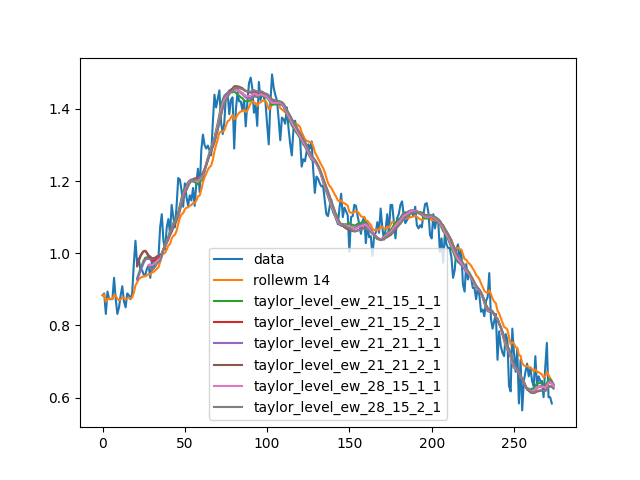

In [322]:
plt.close()
plt.plot(loc_data.fourth_rt_rate.values, label = "data")
# plt.plot(loc_data.rate.values[-(loc_data.shape[0] - window + 1):], label = "data")
# plt.plot(loc_data.rate.rolling(7).mean().values, label = "rollmean 7")
# plt.plot(loc_data.rate.rolling(7).median().values[-(loc_data.shape[0] - window + 1):], label = "rollmedian 7")
# plt.plot(loc_data.rate.rolling(window).mean().values[-(loc_data.shape[0] - window + 1):], label = "rollmean window")
# plt.plot(loc_data.rate.ewm(span=7).mean().values[-(loc_data.shape[0] - window + 1):], label = "rollewm 7")
plt.plot(loc_data.fourth_rt_rate.ewm(span=14).mean().values, label = "rollewm 14")
# plt.plot(loc_data.rate.ewm(span=11).mean().values, label = "rollewm 11")
# plt.plot(loc_data.rate.ewm(span=21).mean().values[-(loc_data.shape[0] - window + 1):], label = "rollewm window")
# plt.plot(beta_hat_taylor[:, 0]**4, label = "taylor_level")
# plt.plot(beta_hat_taylor_1[:, 0]**4, label = "taylor_level_1")
# plt.plot(beta_hat_taylor_2[:, 0]**4, label = "taylor_level_2")
# plt.plot(
#     np.concatenate([np.full(15, np.nan), beta_hat_taylor_ew_15_15_1_1[:, 0]**4], axis=0),
#     label = "taylor_level_ew_15_15_1_1")
# plt.plot(
#     np.concatenate([np.full(15, np.nan), beta_hat_taylor_ew_15_15_2_1[:, 0]**4], axis=0),
#     label = "taylor_level_ew_15_15_2_1")
# plt.plot(
#     np.concatenate([np.full(15, np.nan), beta_hat_taylor_ew_15_15_2_2[:, 0]**4], axis=0),
#     label = "taylor_level_ew_15_15_2_2")
plt.plot(
    np.concatenate([np.full(21, np.nan), beta_hat_taylor_ew_21_15_1_1[:, 0]], axis=0),
    label = "taylor_level_ew_21_15_1_1")
plt.plot(
    np.concatenate([np.full(21, np.nan), beta_hat_taylor_ew_21_15_2_1[:, 0]], axis=0),
    label = "taylor_level_ew_21_15_2_1")
# plt.plot(
#     np.concatenate([np.full(21, np.nan), beta_hat_taylor_ew_21_15_2_2[:, 0]**4], axis=0),
#     label = "taylor_level_ew_21_15_2_2")
plt.plot(
    np.concatenate([np.full(21, np.nan), beta_hat_taylor_ew_21_21_1_1[:, 0]], axis=0),
    label = "taylor_level_ew_21_21_1_1")
plt.plot(
    np.concatenate([np.full(21, np.nan), beta_hat_taylor_ew_21_21_2_1[:, 0]], axis=0),
    label = "taylor_level_ew_21_21_2_1")
# plt.plot(
#     np.concatenate([np.full(21, np.nan), beta_hat_taylor_ew_21_21_2_2[:, 0]**4], axis=0),
#     label = "taylor_level_ew_21_21_2_2")
plt.plot(
    np.concatenate([np.full(28, np.nan), beta_hat_taylor_ew_28_15_1_1[:, 0]], axis=0),
    label = "taylor_level_ew_28_15_1_1")
plt.plot(
    np.concatenate([np.full(28, np.nan), beta_hat_taylor_ew_28_15_2_1[:, 0]], axis=0),
    label = "taylor_level_ew_28_15_2_1")
# plt.plot(
#     np.concatenate([np.full(28, np.nan), beta_hat_taylor_ew_28_15_2_2[:, 0]**4], axis=0),
#     label = "taylor_level_ew_28_15_2_2")
# plt.plot(beta_hat_taylor_by_window_1[:, 0]**4, label = "taylor_level_by_window_1")
# plt.plot(beta_hat_taylor_by_window_2[:, 0]**4, label = "taylor_level_by_window_2")
plt.legend()
plt.show()

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_72683/566300526.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


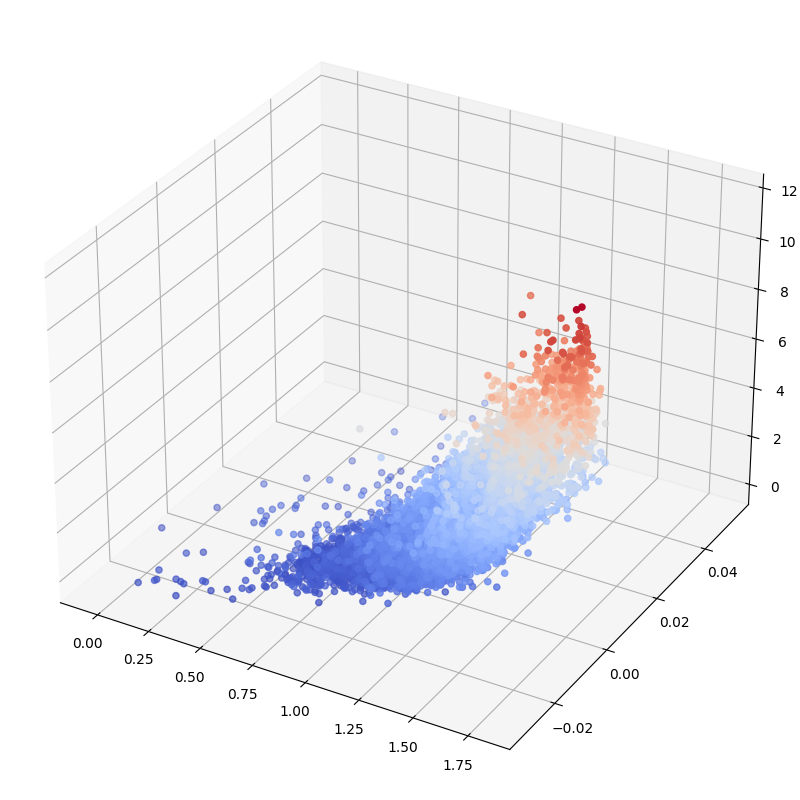

In [475]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)

ax.scatter(data.dropna().fourth_rt_rate_taylor_0,
           data.dropna().fourth_rt_rate_taylor_1,
           data.dropna().rate_h_14,
           c=data.dropna().rate_h_14,
           cmap = cm.coolwarm)
